# Test of CAMB_GammaPrime_Growth
CAMB_GammaPrime_Growth is a modified version of CAMB, where the nonlinear module halofit is modified to allow for a gamma parametrization of growth rate.
- The considered gamma parametrization assumes the form $$f(z)=\Omega_m(z)^{\gamma(z)},$$ where $\gamma(z)=\gamma_0+\gamma_1*z$.
- All changes are limited to within the CAMB nonlinear halofit module. Within which, we rescale the linear matter power spectrum $P_{\mathrm{lin}}(k,z)$ that enters the estimation of the two-halo term $P_{\mathrm{2-halo}}(k,z,P_{\mathrm{lin}})$.
Reference: Eq. 14-16 in [Mead2020][1]

[1]: https://arxiv.org/abs/2009.01858

## Load some basic libraries and check CAMB installation path

In [1]:
import sys, platform, os
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('Minh_paper_style')
import matplotlib.pyplot as plt
from matplotlib.ticker import (FixedLocator, MultipleLocator, FixedFormatter, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import cm
from matplotlib.colors import ListedColormap

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.6 installed at /nfs/turbo/lsa-nguyenmn/cosmo_analysis/cobaya_intel/code/CAMB-Growth/camb


## Set up two cosmologies, with $\gamma=0.55$ (GR-LCDM) and $\gamma=1.0$

## Call CAMB to solve the coupled Bolztmann equations for the given cosmologies, assuming the same primordial power spectrum

## $\gamma=0.55$

In [2]:
cosmo_params = camb.CAMBparams()
### Consider LCDM cosmology with only one massive neutrino, helium then set through the BBN consistency
cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=0.55,gamma1=0.0)
#### Consider the usual power-law initial power spectrum (of primordial fluctuations)
cosmo_params.InitPower.set_params(As=2e-9, ns=0.965, r=0)

redshift_snaphots=[1.5,0.]
kmin=1e-4
kmax=2.0

### Note that here you probably want to extend the k-range to at least 2 kmax being considered later
cosmo_params.set_matter_power(redshifts=redshift_snaphots, kmax=2*kmax);

### Linear power spectra
#cosmo_params.set_dark_energy(w=-0.8, wa=0.2, dark_energy_model='fluid') 
cosmo_params.NonLinear = model.NonLinear_none
results = camb.get_results(cosmo_params)
kh, z, pk_lin = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
np.savetxt('test_pklin_LCDM_z2.txt',np.c_[kh,pk_lin[1,:]])

### Non-linear power spectra (Halofit)
cosmo_params.NonLinear = model.NonLinear_both
cosmo_params.NonLinearModel.set_params(halofit_version='mead2020')
results.calc_power_spectra(cosmo_params)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
np.savetxt('test_pknonlin_LCDM_z2.txt',np.c_[kh,pk_nonlin[1,:]])

## $\gamma=1.0$

In [3]:
cosmo_params = camb.CAMBparams()
### Consider LCDM cosmology with only one massive neutrino, helium then set through the BBN consistency
cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=1.0,gamma1=0.0)
#### Consider the usual power-law initial power spectrum (of primordial fluctuations)
cosmo_params.InitPower.set_params(As=2e-9, ns=0.965, r=0)

redshift_snaphots=[1.5,0.]
kmin=1e-4
kmax=2.0

### Note that here you probably want to extend the k-range to at least 2 kmax being considered later
cosmo_params.set_matter_power(redshifts=redshift_snaphots, kmax=2*kmax);

### Linear power spectra
#cosmo_params.set_dark_energy(w=-0.8, wa=0.2, dark_energy_model='fluid') 
cosmo_params.NonLinear = model.NonLinear_none
results = camb.get_results(cosmo_params)
kh, z, pk_lin_gamma = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
np.savetxt('test_pklin_gamma0_1_z2.txt',np.c_[kh,pk_lin_gamma[1,:]])

### Non-linear power spectra (Halofit)
cosmo_params.NonLinear = model.NonLinear_both
cosmo_params.NonLinearModel.set_params(halofit_version='mead2020')
results.calc_power_spectra(cosmo_params)
kh_nonlin, z_nonlin, pk_nonlin_gamma = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
np.savetxt('test_pknonlin_gamma0_1_z2.txt',np.c_[kh,pk_nonlin_gamma[1,:]])

## Compare linear and nonlinear matter power spectra at z=0.,1.5

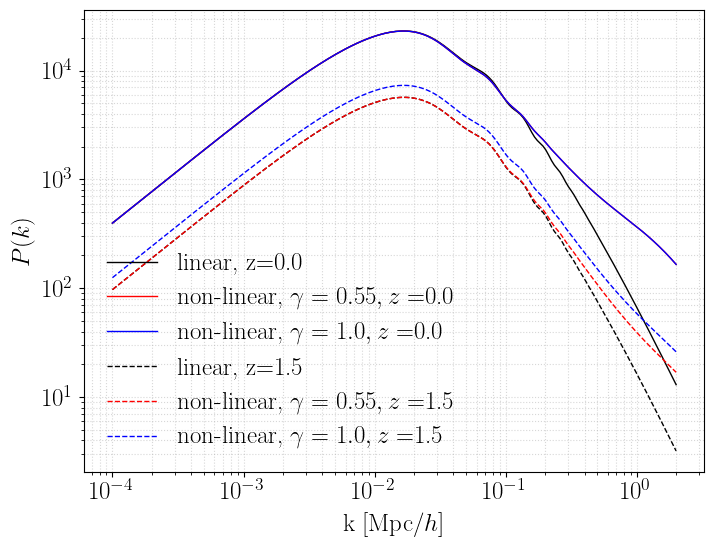

In [4]:
fig,ax=plt.subplots()
for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    ax.loglog(kh, pk_lin[i,:], color='k', ls = line, label='linear, z=%s'%z[i])
    ax.loglog(kh_nonlin, pk_nonlin[i,:], color='r', ls = line, label='non-linear, $\gamma=0.55, z=$%s'%z[i])
    ax.loglog(kh_nonlin, pk_nonlin_gamma[i,:], color='b', ls = line, label='non-linear, $\gamma=1.0, z=$%s'%z[i])
ax.set_xlabel(r'k [Mpc/$h$]')
ax.set_ylabel(r'$P(k)$')
#ax.set_ylim(1,3E4)
ax.grid(True, which="both", ls=":",alpha=0.5)
ax.legend(loc='lower left');

# Below are some further checks of numerical integration of D(z)

## Numerical integral of $D(z)$

In [5]:
import scipy.integrate as integrate

def growth_rate(a,Omega_m,gamma0=0.55,gamma1=0.0):
    z=-1+1./a
    gamma=gamma0+gamma1*z
    growth_rate=np.power(Omega_m,gamma)
    return growth_rate

def growth_factor(a,growth_rate,dx=1E-4):
    integrand=[]
    for i,a_i in enumerate(a):
        integrand.append(np.trapz(-growth_rate[i:]/a[i:],a[i:]))
    integrand=np.asarray(integrand)
    growth_factor=np.exp(integrand)
    return growth_factor

## Check if the numerical result makes sense for LCDM

In [6]:
cosmo_params = camb.CAMBparams()
### Consider LCDM cosmology with only one massive neutrino, helium then set through the BBN consistency
cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=0.55,gamma1=0.0)

#### Consider the usual power-law initial power spectrum (of primordial fluctuations)
cosmo_params.InitPower.set_params(As=2e-9, ns=0.965, r=0)

a=np.linspace(0.001,1.0,150)
redshift_snaphots=[1.5,0.]
kmin=1e-4
kmax=2.0
### Note that here you probably want to extend the k-range to at least 2 kmax being considered later
cosmo_params.set_matter_power(redshifts=redshift_snaphots, kmax=2*kmax)

cosmo_params.NonLinear = model.NonLinear_none
results = camb.get_results(cosmo_params)
kh, z, pk_lin_LCDM = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)

cosmo_params.NonLinear = model.NonLinear_both
results.calc_power_spectra(cosmo_params)
kh_nonlin, z_nonlin, pk_nonlin_LCDM = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)

Omega_cdm=results.get_Omega('cdm',z=-1.+1./a)
Omega_b=results.get_Omega('baryon',z=-1.+1./a)
Omega_m=Omega_cdm+Omega_b

f=growth_rate(a,Omega_m)
D=growth_factor(a,f)

In [7]:
a_check=np.linspace(0.001,1.0,150)
z_check=-1+1./a_check
cosmo_params.set_matter_power(redshifts=z_check, kmax=2*kmax);
results = camb.get_results(cosmo_params)
sigma8_z0=results.get_sigma8_0()
print(sigma8_z0)
D_check=results.get_sigma8()/sigma8_z0

0.8025233044490516


## Plot linear growth rate and growth factor for LCDM

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


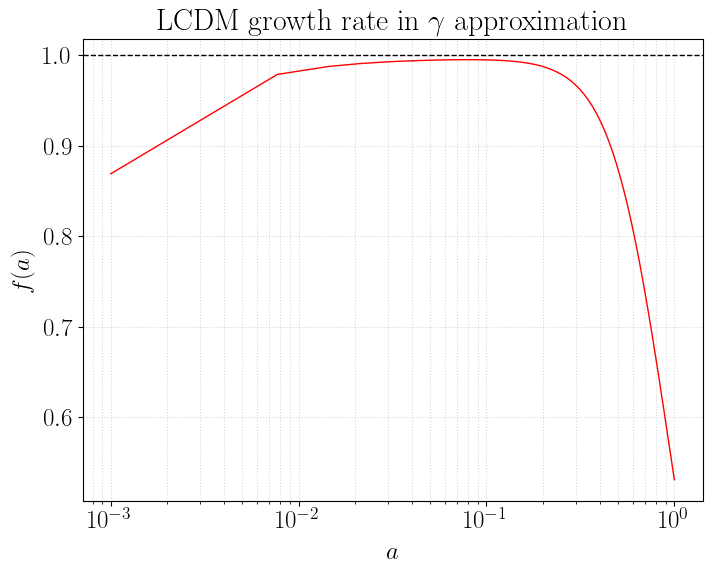

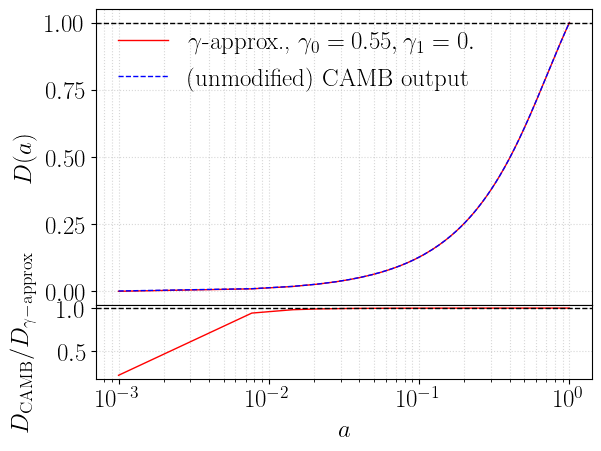

In [8]:
fig,ax=plt.subplots()
ax.semilogx(a,f,ls='-',c='r')
ax.axhline(y=1.0,ls='--',c='k')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$f(a)$')
ax.grid(True, which="both", ls=":",alpha=0.5)
ax.legend(loc='lower left')
ax.set_title(r'LCDM growth rate in $\gamma$ approximation');

fig, ax = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0., 'wspace':0., 'height_ratios':[8, 2]}, figsize=(6.4, 4.8))
ax[0].semilogx(a,D,ls='-',c='r',label=r'$\gamma$-approx., $\gamma_0=0.55,\gamma_1=0.$')
ax[0].semilogx(a_check,D_check,ls='--',c='b',label='(unmodified) CAMB output')
ax[0].axhline(y=1.0,ls='--',c='k')
ax[1].semilogx(a,D/D_check,c='r')
ax[1].axhline(y=1.0,ls='--',c='k')
ax[1].grid(True,which="both",ls=":",alpha=0.5)
ax[1].set_ylabel(r'$D_{\mathrm{CAMB}}/D_{\gamma-\mathrm{approx}}$', labelpad=15)
ax[1].set_xlabel(r'$a$')
ax[0].set_ylabel(r'$D(a)$')
ax[0].grid(True, which="both", ls=":",alpha=0.5)
ax[0].legend(loc='upper left')
#ax[0].set_title('Linear growth factor - CAMB vs. $\gamma$ approximation');

### Compute D(a) for the latter and find D(a) closest to z=2.0

In [9]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx,array[idx]

a=np.linspace(0.001,1.0,1000)
redshift_snaphots=[1.5,0.]
z_0=redshift_snaphots[0]
a_0=1./(1.+z_0)
idx,value=find_nearest(a,a_0)
kmin=1e-4
kmax=2.0
print(value)

cosmo_params = camb.CAMBparams()
### Consider LCDM cosmology with only one massive neutrino, helium then set through the BBN consistency
cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=0.55,gamma1=0.0)
#### Consider the usual power-law initial power spectrum (of primordial fluctuations)
cosmo_params.InitPower.set_params(As=2e-9, ns=0.965, r=0)

cosmo_params.set_matter_power(redshifts=redshift_snaphots, kmax=2*kmax);
results = camb.get_results(cosmo_params)

Omega_cdm=results.get_Omega('cdm',z=-1.+1./a)
Omega_b=results.get_Omega('baryon',z=-1.+1./a)
Omega_m=Omega_cdm+Omega_b

f=growth_rate(a,Omega_m,gamma0=0.55,gamma1=0.0)
D=growth_factor(a,f)

cosmo_params = camb.CAMBparams()
### Consider LCDM cosmology with only one massive neutrino, helium then set through the BBN consistency
cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=1.0,gamma1=0.0)
#### Consider the usual power-law initial power spectrum (of primordial fluctuations)
cosmo_params.InitPower.set_params(As=2e-9, ns=0.965, r=0)

cosmo_params.set_matter_power(redshifts=redshift_snaphots, kmax=2*kmax);
results = camb.get_results(cosmo_params)

Omega_cdm_gamma=results.get_Omega('cdm',z=-1.+1./a)
Omega_b_gamma=results.get_Omega('baryon',z=-1.+1./a)
Omega_m_gamma=Omega_cdm_gamma+Omega_b_gamma

f_gamma=growth_rate(a,Omega_m_gamma,gamma0=1.0,gamma1=0.0)
D_gamma=growth_factor(a,f_gamma)

pk_gamma=pk_lin[0,:]*(D_gamma[idx]**2)
pk_check=pk_lin[0,:]*(D[idx]**2)

0.4


### Compare different growth factors D(a)

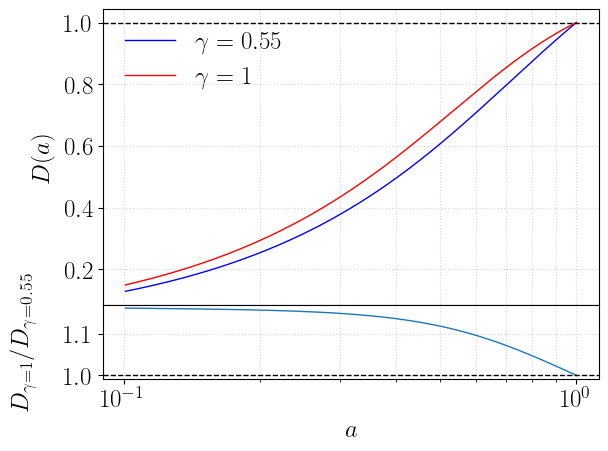

In [10]:
fig, ax = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0., 'wspace':0., 'height_ratios':[8, 2]}, figsize=(6.4, 4.8))
cutoff=100
ax[0].semilogx(a[cutoff:],D[cutoff:],ls='-',c='b',label=r'$\gamma=0.55$')
ax[0].semilogx(a[cutoff:],D_gamma[cutoff:],ls='-',c='r',label=r'$\gamma=1$')
ax[0].axhline(y=1.0,ls='--',c='k')
ax[0].grid(True, which="both", ls=":",alpha=0.5)
ax[1].set_xlabel(r'$a$')
ax[0].set_ylabel(r'$D(a)$')
ax[1].semilogx(a[cutoff:],D_gamma[cutoff:]/D[cutoff:])
ax[1].axhline(y=1.0,ls='--',c='k')
ax[1].grid(True,which="both",ls=':',alpha=0.5)
ax[1].set_ylabel(r'$D_{\gamma=1}/D_{\gamma=0.55}$',labelpad=20)
ax[0].legend(loc='upper left');
#ax[0].set_title('LCDM vs. $\gamma_0=0.55,\gamma_1=1.0$ growth factor');

### Compare linear $P(k,z=1.5)$ rescaled by different growth factors

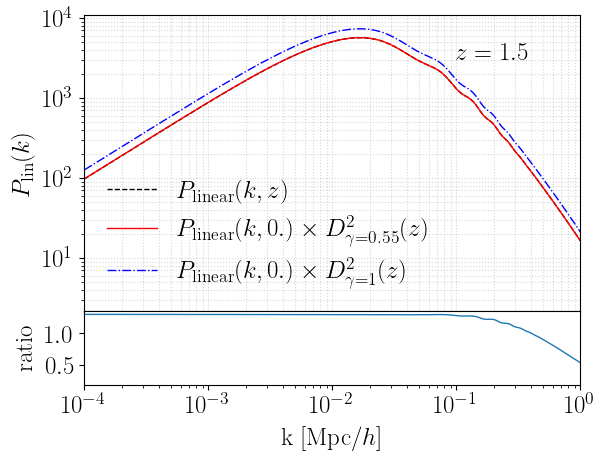

In [11]:
fig, ax = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0., 'wspace':0., 'height_ratios':[8, 2]}, figsize=(6.4, 4.8))
ax[0].loglog(kh, pk_lin[1,:], color='k', ls = '--', label=r'$P_{\mathrm{linear}}(k,z)$')
ax[0].loglog(kh, pk_check, color='r', ls = '-', label=r'$P_{\mathrm{linear}}(k,0.)\times D_{\gamma=0.55}^2(z)$')
ax[0].loglog(kh, pk_gamma, color='b', ls = '-.', label=r'$P_{\mathrm{linear}}(k,0.)\times D_{\gamma=1}^2(z)$')
ax[0].text(0.75, 0.85,r'$z=1.5$',transform=ax[0].transAxes)
ax[0].set_xlim(1E-4,1)
ax[1].set_xlabel(r'k [Mpc/$h$]')
ax[0].set_ylabel(r'$P_{\mathrm{lin}}(k)$')
ax[0].grid(True, which="both", ls=":",alpha=0.5)
ax[0].legend(loc='lower left')
ax[1].semilogx(kh,pk_gamma/pk_nonlin[1,:])
ax[1].set_ylabel(r'ratio');
#ax[0].set_title(r'LCDM vs. $\gamma_0=0.55,\gamma_1=1.0$ linear power at z=%s'%z[1]);

### Compare the ratio between nonlinear $P(k,z=2.0)$ and the ratio between corresponding $D(z)$

In [ ]:
cosmo_params = camb.CAMBparams()
### Consider LCDM cosmology with only one massive neutrino, helium then set through the BBN consistency
cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=1.0,gamma1=0.0)

#### Consider the usual power-law initial power spectrum (of primordial fluctuations)
cosmo_params.InitPower.set_params(As=2e-9, ns=0.965, r=0)

a=np.linspace(0.001,1.0,1000)
redshift_snaphots=[1.5,0.]

kmin=1e-4
kmax=2.0
### Note that here you probably want to extend the k-range to at least 2 kmax being considered later
cosmo_params.set_matter_power(redshifts=redshift_snaphots, kmax=2*kmax);

#cosmo_params.NonLinear = model.NonLinear_none
results = camb.get_results(cosmo_params)
kh, z, pk_lin_gamma = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
np.savetxt('test_pklin_gamma_z2.txt',(kh,pk_lin_gamma[1,:]))

### Non-linear power spectra (Halofit)
cosmo_params.NonLinear = model.NonLinear_both
cosmo_params.NonLinearModel.set_params(halofit_version='mead2020')
results = camb.get_results(cosmo_params)
#results.calc_power_spectra(cosmo_params)
kh_nonlin, z_nonlin, pk_nonlin_gamma = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
np.savetxt('test_pknonlin_gamma_z2.txt',(kh,pk_nonlin_gamma[1,:]))

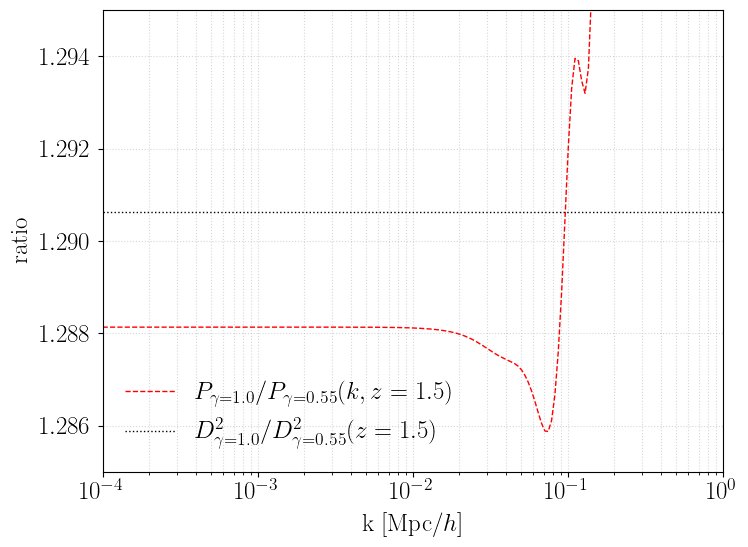

In [15]:
fig,ax=plt.subplots()
ax.semilogx(kh, pk_nonlin_gamma[1,:]/pk_nonlin[1,:], color='r', ls = line, label=r'$P_{\gamma=1.0}/P_{\gamma=0.55}(k,z=1.5)$')
ax.axhline((D_gamma[idx]/D[idx])**2,ls=':',color='k',label='$D^2_{\gamma=1.0}/D^2_{\gamma=0.55}(z=1.5)$')
ax.set_xlabel(r'k [Mpc/$h$]')
ax.set_ylabel(r'ratio')
ax.set_ylim(1.285,1.295)
ax.set_xlim(1E-4,1)
ax.grid(True, which="both", ls=":",alpha=0.5)
ax.legend(loc='lower left');